### Many-body Entanglement and Tensor Networks
Tutorials based on the 2017 Perimeter Scholar International Condensed Matter Review course taught by Guifre Vidal

# <span style="color:#0C45A9">Python tutorial 7</span>

In this tutorial we will work within the free fermion formalism.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig

import warnings
warnings.filterwarnings('ignore')

## 7.1. Free fermion system: energy

This is a system of $2N$ Majorana modes. The algebra is:
<center> $\psi_I \;,\; I \equiv(n,\alpha)\quad\text{with}\; n=1,2,...,N\;\;\text{and}\;\;\alpha=1,2\;,$ <br>
<p align="left">where $n$ is used to denote the pair and $\alpha$ to refer to the mode within each pair. <br>
These operators also obey hermitianity and anticommutativity:
<center> $\psi_I^{\dagger}=\psi_I\;,\; \{\psi_I,\psi_J\}=\delta_{IJ}$.<br>
<br>
<p align="left">We aim to simultaneously diagonalise the Hamiltonian (given by matrix $C$) and the translation operator ($T$).</p>
<br>
<center> $C \left\vert \psi_m \right \rangle = e_m\left\vert \psi_m \right \rangle  $ <center> 
    <br>
<center> $T \left\vert \psi_m \right \rangle = e^{ik_m}\left\vert \psi_m \right \rangle  $ <center>
    <br>
<p align="left">This will give us an eigenbasis of size $N$:
<center> $\{e_m\}, \{k_m\}$  where  $m=1,...,N$ <center> 
<br>
 <p align="left">Which can be mapped back to our $2^N$ basis:
<center> $\{E_{\alpha}\}, \{K_{\alpha}\}$  where  ${\alpha}=1,...,2^N$ <center> 
<br>

### 7.1.1. Functions for Hamiltonian and Translation operators

#### b) Building $N\times N$ Hamiltonian matrix $A$

In [30]:
def build_matrix_A(N, bc=1): # bc=1 (default) for PBC and bc=-1 for APBC
    A = np.zeros((N, N)) 
    for n in range(N-1):
        A[n, n+1] = -1
        A[n+1, n] = -1
    A[N-1,0] = -bc
    A[0,N-1] = -bc
    return A

#### a) Building translation operator $T_f$

In [21]:
def build_T_operator(N, bc=1): # bc=1 (default) for PBC and bc=-1 for APBC
    T_op = np.zeros((N,N))
    for n in range(N-1):
        T_op[n,n+1] = 1
        
    T_op[N-1,0] = bc
    return T_op

### 7.1.2. Single particle system: diagonalization of  $A$ and $T_f$.

We obtain the single particle energies $e_\alpha$ and momenta $k_{\alpha}$.

In [50]:
def diagonalise_A_T(A, T_op):
    N = int(np.shape(A)[0])
    M = A.dot(np.eye(N) + 0.13*T_op)+0.05*T_op
    D, U = eig(M)
    
    e = np.real(np.diag((U.conj().T).dot(A).dot(U)))
    k = np.angle(np.diag((U.conj().T).dot(T_op).dot(U)))
    
    #sort from smaller to largest
    ord_idx = np.argsort(e)
    e = e[ord_idx]
    k = k[ord_idx]
    
    return e, k

In [55]:
N = 400

#PERIODIC BC
A_pbc = build_matrix_A(N, bc = 1)
T_pbc = build_T_operator(N, bc = 1)
e_pbc, k_pbc = diagonalise_A_T(A_pbc, T_pbc)
#APERIODIC BC
A_apbc = build_matrix_A(N, bc = -1)
T_apbc = build_T_operator(N, bc = -1)
e_apbc, k_apbc = diagonalise_A_T(A_apbc, T_apbc)

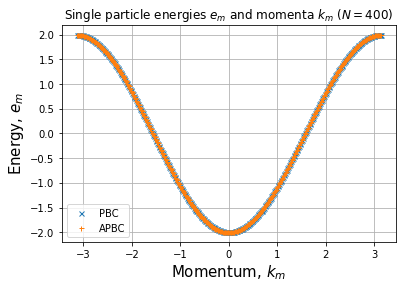

In [56]:
plt.title("Single particle energies $e_m$ and momenta $k_m$ ($N=$%s)" %(N))
plt.grid()
plt.ylabel(r"Energy, $e_m$", fontsize = 15)
plt.xlabel(r"Momentum, $k_m$", fontsize = 15)
plt.plot(k_pbc, e_pbc, 'x', ms=5, label = 'PBC')
plt.plot(k_apbc, e_apbc, '+', ms=5, label = 'APBC')
plt.legend()
plt.show()

### 7.1.3. Correlation matrix $M$ for ground-state ($N$ sites)

In [58]:
def obtain_M(A, T_op):
    N = int(np.shape(A)[0])
    M = A.dot(np.eye(N) + 0.13*T_op)+0.05*T_op
    D, U = eig(M)
    
    e = np.real(np.diag((U.conj().T).dot(A).dot(U)))
    k = np.angle(np.diag((U.conj().T).dot(T_op).dot(U)))
    
    ord_idx = np.argsort(e)
    e = e[ord_idx]
    k = k[ord_idx]
    U = U[:, ord_idx]
    
    M = (U.dot(np.diag(np.sign(e)))).dot(U.conj().T)
    
    return M

In [63]:
A_apbc = build_matrix_A(N, bc = -1)
T_apbc = build_T_operator(N, bc = -1)

M = obtain_M(A_apbc, T_apbc)

print("Is M successfully real?", np.allclose(M, np.real(M)))
M = np.real(M) #cleaning neglible imaginary part
print("Is M successfully symmetric?", np.allclose(M, (M+M.conj().T)/2))

Is M successfully real? True
Is M successfully symmetric? True


### 7.1.4. Reduced correlation matrix $M^A$

In [65]:
L_max = N//2
L_s = np.arange(1,L_max+1)

M_A = M[0:L_max, 0:L_max]

### 7.1.5. Entanglement entropy in ground-state

In [93]:
def ent_entropy_fermi(M):
    p = np.shape(M)[0]
    entropy = np.zeros(p)
    for n in range(p+1):
        M_red = M[:n, :n]
        u,v = eig(M_red)
        for m in range(n):
            x = u[m]
            if abs(x) < 1:
                entropy[n-1] -= (1+x)/2*np.log2((1+x)/2) + (1-x)/2*np.log2((1-x)/2)
            elif abs(x) > 1+1e-5:
                print("warning: (absolute) single particle eigenvalue > 1")
    return entropy

In [94]:
entropy_numerical = ent_entropy_fermi(M_A)

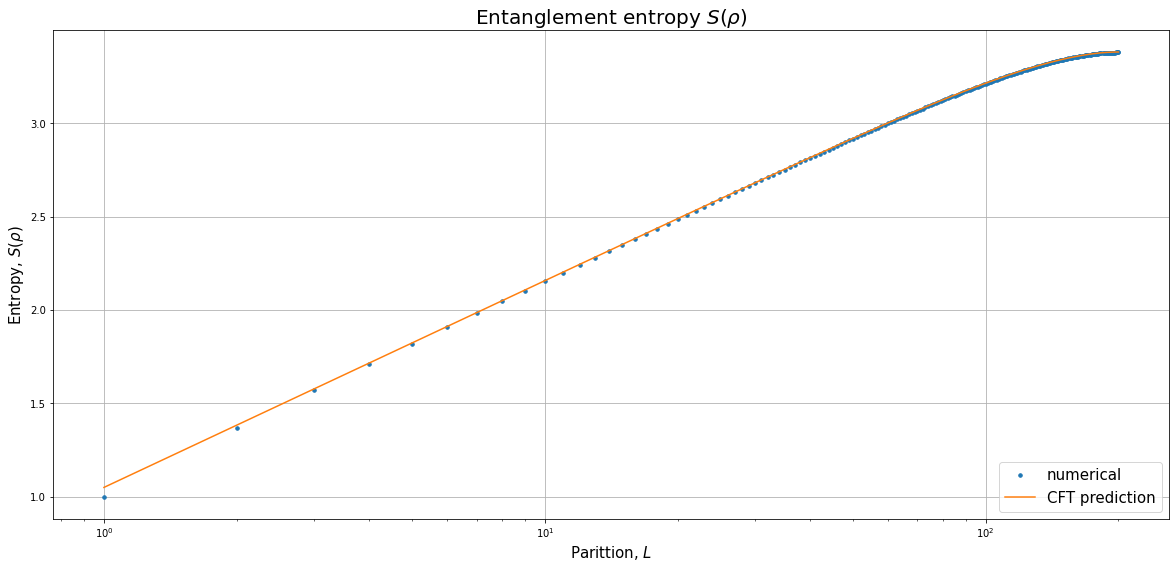

In [95]:
cft_ent_entropy = [1/3*(np.log2(N/np.pi*np.sin(n*np.pi/N)))+1.05 for n in L_s] #c = 1
plt.title(r"Entanglement entropy $S(\rho)$", fontsize = 20)
plt.xscale('log')
plt.grid()
plt.ylabel(r"Entropy, $S(\rho)$", fontsize = 15)
plt.xlabel(r"Parittion, $L$", fontsize = 15)
plt.plot(L_s, entropy_numerical, '.', ms=7, label = 'numerical')
plt.plot(L_s, cft_ent_entropy, label = 'CFT prediction')
plt.legend(loc = 'lower right', fontsize = 15)
plt.show()

### 7.1.6. Entanglement spectrum ground-state

In [98]:
def configurations(n, fN):
    """
    Generates the configurations $\vec{x}.
     n = configuration number
     fN = size to pad to
    """
    conf_int = bin(n).replace("0b", "")
    conf_list = [int(i) for i in conf_int]
    conf_list = conf_list[::-1]
    fill_list = [0 for i in range(fN-len(conf_list))]
    conf_list += fill_list
    return conf_list

In [99]:
def ent_spectrum_fermi(M, fN):
    mu, U = eig(M)
    mu = np.sort(abs(mu))
    N = len(mu)
    if fN > N:
        fN=N
        
    P = np.ones(2**fN).dot(np.prod((1+mu)/2))
    for n in range(2**fN):
        x = configurations(n, fN)
        for m in range(fN):
            if x[m] == 1:
                P[n] *= (1-mu[m])/(1+mu[m])
    return np.sort(P)

In [103]:
ent_spectrum = ent_spectrum_fermi(M_A, 10)
Q = np.sort(-np.log(ent_spectrum))
Q = (Q-Q[0])/(Q[1]-Q[0])

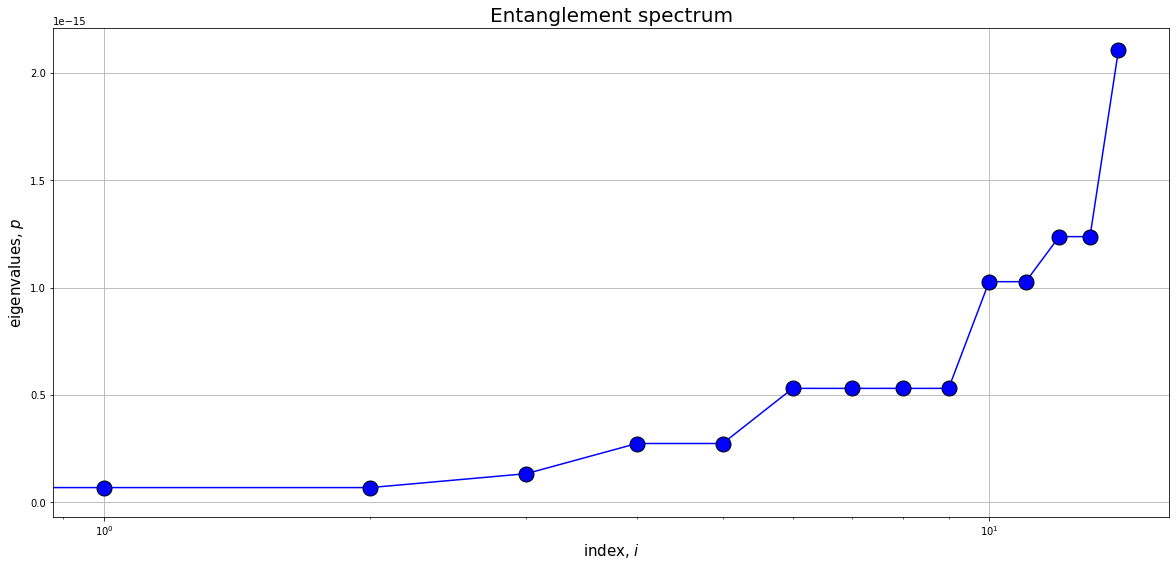

In [107]:
first = 15
plt.title(r"Entanglement spectrum", fontsize = 20)
plt.xscale('log')
plt.grid()
plt.ylabel(r"eigenvalues, $p$", fontsize = 15)
plt.xlabel(r"index, $i$", fontsize = 15)
plt.plot(ent_spectrum[:first],  marker = "o", color = "b", ms=15, markeredgecolor= "black")
plt.show()